In [1]:
# import pyvisa
import matplotlib.pyplot as plt
import numpy as np
import srlock
import time
from scipy.optimize import curve_fit


In [5]:
rm = pyvisa.ResourceManager()

rm.list_resources()

NameError: name 'pyvisa' is not defined

In [6]:
%%time
res = "GPIB0::8::INSTR"

with srlock.SR830(resource=res, timeout=10000) as lia:
    print("IDN:", lia.idn())  # IDN?
    lia.outx(1)  # ensure responses to GPIB
    print("Current phase (deg):", lia.phas())  # PHAS?
    lia.fmod(1)  # internal reference
    print("Freq set, read back:", lia.freq())
    lia.slvl(2.4)
    print(lia.slvl())


/home/sdiptanuj/.local/lib/python3.13/site-packages/gpib_ctypes/gpib/gpib.py:54: UserWarning: GPIB library not found. Please manually load it using _load_lib(filename). All GPIB functions will raise OSError until the library is manually loaded.
  warnings.warn(message)


CPU times: user 240 ms, sys: 50.5 ms, total: 290 ms
Wall time: 2.06 s


ValueError: gpib_ctypes is installed but could not locate the gpib library.
Please manually load it using:
  gpib_ctypes.gpib.gpib._load_lib(filename)
before importing pyvisa.

In [7]:
res = "GPIB0::8::INSTR"
filename_attr = ""
last_filename = ""

base = 1.5
# Starting data collection
freqRange = [i for i in range(20_000, 100_000, 2000)]
# freqRange = [np.floor((base)**i) for i in range(15, int(np.log(100_000)/np.log(base)) + 1)]
freqRange.append(100_000)
# voltRange = [i / 10 for i in range(0, 50)]
voltRange = [1e-2]
R0 = 2200

# Data collection
data = np.zeros((len(freqRange), len(voltRange), 4))
noise = np.zeros((len(freqRange), len(voltRange), 4))

# Config
run = 15
timeConst = 0.1  # in seconds


In [8]:
freqRange, len(freqRange)

([20000,
  22000,
  24000,
  26000,
  28000,
  30000,
  32000,
  34000,
  36000,
  38000,
  40000,
  42000,
  44000,
  46000,
  48000,
  50000,
  52000,
  54000,
  56000,
  58000,
  60000,
  62000,
  64000,
  66000,
  68000,
  70000,
  72000,
  74000,
  76000,
  78000,
  80000,
  82000,
  84000,
  86000,
  88000,
  90000,
  92000,
  94000,
  96000,
  98000,
  100000],
 41)

In [ ]:
%%time
with srlock.SR830(resource=res, timeout=10000) as lia:
    global filename_attr, freqRange, voltRange, data, noise, run, timeConst
    print("IDN:", lia.idn())  # IDN?
    lia.outx(1)  # ensure responses to GPIB
    print("Current phase (deg):", lia.phas())  # PHAS?
    lia.fmod(1)  # internal reference
    print("Freq set, read back:", lia.freq())
    lia.oflt(8)
    # lia.sens(21)
    # lia.aphs()
    # time.sleep(30)
    time.sleep(timeConst)

    for i in range(len(freqRange)):
        for j in range(len(voltRange)):
            print(j)
            try:
                lia.slvl(voltRange[j])
                # if (j == 0):
                #     lia.agan()
                #     time.sleep(30*timeConst)
                lia.freq(freqRange[i])
                # lia.aphs()
                # time.sleep(3*timeConst)
                #lia.agan()
                #time.sleep(3*timeConst)
                print("Frequency:", freqRange[i], "Voltage:", voltRange[j])
                time.sleep(30*timeConst)
                # Poll for values
                runData = np.zeros((run, 4))
                for o in range(run):
                    snap_vals = lia.snap([1, 2, 3, 4])
                    print(snap_vals)
                    runData[o, 0] = snap_vals[0]
                    runData[o, 1] = snap_vals[1]
                    runData[o, 2] = snap_vals[2]
                    runData[o, 3] = snap_vals[3]
                    time.sleep(5*timeConst)
                m = np.mean(runData, axis=0)
                n = np.std(runData, axis=0)
                data[i, j] = m
                noise[i, j] = n
            except Exception as e:
                print(f"{e} DETECTED. SAVING PARTIAL DATA.")
                filename_attr = "incomplete"
                break


# Save data
last_filename = f"johnson_act_noise_data_{time.time():.0f}.npz"
np.savez(last_filename, freqRange=freqRange, voltRange=voltRange, data=data, noise=noise)
# change sync_filtero_act_noise_data_1762513140 to johnson1k_act_noise_data_1762513140

In [9]:

import scienceplots
plt.style.use(['science'])
plt.rcParams.update({'font.size': 20})

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
voltRange = [2.5]
R0 = 1000


In [3]:
# loaded_data = np.load(last_filename)
#bad initial data
# loaded_data = np.load("data_1762421840.npz")

#proper data
loaded_data1 = np.load("data/data_1762423987.npz")
loaded_data2 = np.load("data/data_1762425388-Copy1.npz")
loaded_data3 = np.load("data/data_1762425388.npz")
loaded_data4 = np.load("data/data_1762426604.npz")
loaded_data5 = np.load("data/data_1762427561.npz")

#Quite different values of the resistance??
loaded_data6 = np.load("data/data_1762507995.npz")
loaded_data7 = np.load("data/data_1762510386.npz")

# # Noise data and actual data, need to check
# loaded_data = np.load("data/noise_data_1762428332.npz")
# loaded_data = np.load("data/noise_data_1762428563.npz")
# loaded_data = np.load("data/noise_data_1762428838.npz")
# loaded_data = np.load("data/noise_data_1762507995.npz")
# loaded_data = np.load("data/noise_data_1762510386.npz")

# # Johnsson noise data
# loaded_data = np.load("data/johnson1k_act_noise_data_1762513140.npz")
# loaded_data = np.load("data/johnson_act_noise_data_1762513859.npz")
# loaded_data = np.load("data/johnson_act_noise_data_1762514739.npz")


#last noise data
# loaded_data = np.load("data/sync_filteroff_act_noise_data_1762511814.npz")
# loaded_data = np.load("data/sync_filteron_act_noise_data_1762512505.npz")
# loaded_data = np.load("data/sync_filtero_act_noise_data_1762513140.npz")
# loaded_data = np.load("data/noise_data_1762507995.npz")
# data_1762427561.npz

In [4]:
#X = loaded_data["data"][:, :, 0]
#Y = loaded_data["data"][:, :, 1]
#R = loaded_data["data"][:, :, 2]


X1 = loaded_data1["data"][:, :, 0].flatten()
X2 = loaded_data2["data"][:, :, 0].flatten()
X3 = loaded_data3["data"][:, :, 0].flatten()
X4 = loaded_data4["data"][:, :, 0].flatten()
X5 = loaded_data5["data"][:, :, 0].flatten()
X6 = loaded_data6["data"][:, :, 0].flatten()
X7 = loaded_data7["data"][:, :, 0].flatten()

Y1 = loaded_data1["data"][:, :, 1].flatten()
Y2 = loaded_data2["data"][:, :, 1].flatten()
Y3 = loaded_data3["data"][:, :, 1].flatten()
Y4 = loaded_data4["data"][:, :, 1].flatten()
Y5 = loaded_data5["data"][:, :, 1].flatten()
Y6 = loaded_data6["data"][:, :, 1].flatten()
Y7 = loaded_data7["data"][:, :, 1].flatten()

R1 = loaded_data1["data"][:, :, 2].flatten()
R2 = loaded_data2["data"][:, :, 2].flatten()
R3 = loaded_data3["data"][:, :, 2].flatten()
R4 = loaded_data4["data"][:, :, 2].flatten()
R5 = loaded_data5["data"][:, :, 2].flatten()
R6 = loaded_data6["data"][:, :, 2].flatten()
R7 = loaded_data7["data"][:, :, 2].flatten()


Theta1 = loaded_data1["data"][:, :, 3].flatten()
Theta2 = loaded_data2["data"][:, :, 3].flatten()
Theta3 = loaded_data3["data"][:, :, 3].flatten()
Theta4 = loaded_data4["data"][:, :, 3].flatten()
Theta5 = loaded_data5["data"][:, :, 3].flatten()
Theta6 = loaded_data6["data"][:, :, 3].flatten()
Theta7 = loaded_data7["data"][:, :, 3].flatten()
# Theta = loaded_data["data"][:, :, 3]
freqRange_coll1 = loaded_data1["freqRange"][:]
freqRange_coll2 = loaded_data2["freqRange"][:]
freqRange_coll3 = loaded_data3["freqRange"][:]
freqRange_coll4 = loaded_data4["freqRange"][:]
freqRange_coll5 = loaded_data5["freqRange"][:]
freqRange_coll6 = loaded_data6["freqRange"][:]
freqRange_coll7 = loaded_data7["freqRange"][:]




Resistance1 = 1e3 * R0 * R1 / voltRange[0]
Resistance2 = 1e3 * R0 * R2 / voltRange[0]
Resistance3 = 1e3 * R0 * R3 / voltRange[0]
Resistance4 = 1e3 * R0 * R4 / voltRange[0]
Resistance5 = 1e3 * R0 * R5 / voltRange[0]
Resistance6 = 1e3 * R0 * R6 / voltRange[0]
Resistance7 = 1e3 * R0 * R7 / voltRange[0]

ResistanceX1 = 1e3 * R0 * X1 / voltRange[0]
ResistanceX2 = 1e3 * R0 * X2 / voltRange[0]
ResistanceX3 = 1e3 * R0 * X3 / voltRange[0]
ResistanceX4 = 1e3 * R0 * X4 / voltRange[0]
ResistanceX5 = 1e3 * R0 * X5 / voltRange[0]
ResistanceX6 = 1e3 * R0 * X6 / voltRange[0]
ResistanceX7 = 1e3 * R0 * X7 / voltRange[0]


In [5]:
noiseX1 = np.asarray(loaded_data1["noise"][:, :, 0].flatten())
noiseX2 = np.asarray(loaded_data2["noise"][:, :, 0].flatten())
noiseX3 = np.asarray(loaded_data3["noise"][:, :, 0].flatten())
noiseX4 = np.asarray(loaded_data4["noise"][:, :, 0].flatten())
noiseX5 = np.asarray(loaded_data5["noise"][:, :, 0].flatten())
noiseX6 = np.asarray(loaded_data6["noise"][:, :, 0].flatten())
noiseX7 = np.asarray(loaded_data7["noise"][:, :, 0].flatten())

noiseR1 = loaded_data1["noise"][:, :, 2].flatten()
noiseR2 = loaded_data2["noise"][:, :, 2].flatten()
noiseR3 = loaded_data3["noise"][:, :, 2].flatten()
noiseR4 = loaded_data4["noise"][:, :, 2].flatten()
noiseR5 = loaded_data5["noise"][:, :, 2].flatten()
noiseR6 = loaded_data6["noise"][:, :, 2].flatten()
noiseR7 = loaded_data7["noise"][:, :, 2].flatten()


noiseY1 = loaded_data1["noise"][:, :, 1].flatten()
noiseY2 = loaded_data2["noise"][:, :, 1].flatten()
noiseY3 = loaded_data3["noise"][:, :, 1].flatten()
noiseY4 = loaded_data4["noise"][:, :, 1].flatten()
noiseY5 = loaded_data5["noise"][:, :, 1].flatten()
noiseY6 = loaded_data6["noise"][:, :, 1].flatten()
noiseY7 = loaded_data7["noise"][:, :, 1].flatten()

noiseTheta1 = loaded_data1["noise"][:, :, 3].flatten()
noiseTheta2 = loaded_data2["noise"][:, :, 3].flatten()
noiseTheta3 = loaded_data3["noise"][:, :, 3].flatten()
noiseTheta4 = loaded_data4["noise"][:, :, 3].flatten()
noiseTheta5 = loaded_data5["noise"][:, :, 3].flatten()
noiseTheta6 = loaded_data6["noise"][:, :, 3].flatten()
noiseTheta7 = loaded_data7["noise"][:, :, 3].flatten()

In [8]:
resPoints = [3,4,5] #These are the datapoints that are most stable for almost all runs

avRes = 0
noiseRes = 0
denom = 0
for i in resPoints:
    avRes += noiseR1[i]*Resistance1[i] + noiseR2[i]*Resistance2[i] + noiseR3[i]*Resistance3[i] + noiseR4[i]*Resistance4[i] + noiseR5[i]*Resistance5[i] 
    noiseRes += noiseR1[i]**2 + noiseR2[i]**2 + noiseR3[i]**2 + noiseR4[i]**2 + noiseR5[i]**2
    
    denom += noiseR1[i] + noiseR2[i] + noiseR3[i] + noiseR4[i] + noiseR5[i] + noiseR6[i] + noiseR7[i]
res = avRes/denom
print("Resistance is: ", res)
print("Noise in Resistance is: ", np.sqrt(noiseRes)/denom)

Resistance is:  0.2705565109810187
Noise in Resistance is:  0.07130564764620181


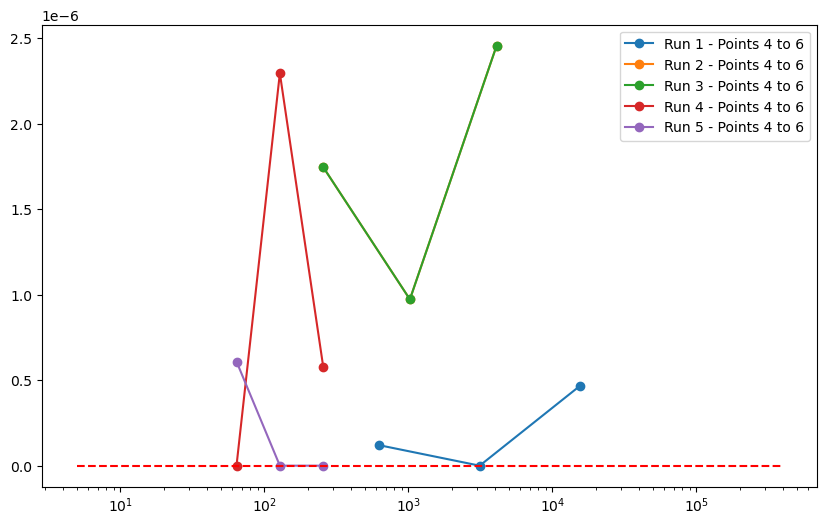

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale('log')
ax.plot(freqRange_coll1[3:6], noiseR1[3:6]*Resistance1[3:6], 'o-', label='Run 1 - Points 4 to 6')
ax.plot(freqRange_coll2[3:6], noiseR2[3:6]*Resistance2[3:6], 'o-', label='Run 2 - Points 4 to 6')
ax.plot(freqRange_coll3[3:6], noiseR3[3:6]*Resistance3[3:6], 'o-', label='Run 3 - Points 4 to 6')
ax.plot(freqRange_coll4[3:6], noiseR4[3:6]*Resistance4[3:6], 'o-', label='Run 4 - Points 4 to 6')
ax.plot(freqRange_coll5[3:6], noiseR5[3:6]*Resistance5[3:6], 'o-', label='Run 5 - Points 4 to 6')
# ax.plot(freqRange_coll6[3:6], noiseR6[3:6]*Resistance6[3:6], 'o-', label='Run 6 - Points 4 to 6')
# ax.plot(fre
# 
# qRange_coll7[3:6], noiseR7[3:6]*Resistance7[3:6], 'o-', label='Run 7 - Points 4 to 6')
ax.legend()
ax.plot(freqRange_coll1, 4e-21 * res * np.ones_like(freqRange_coll1), 'r--', label='Theoretical Johnson Noise')

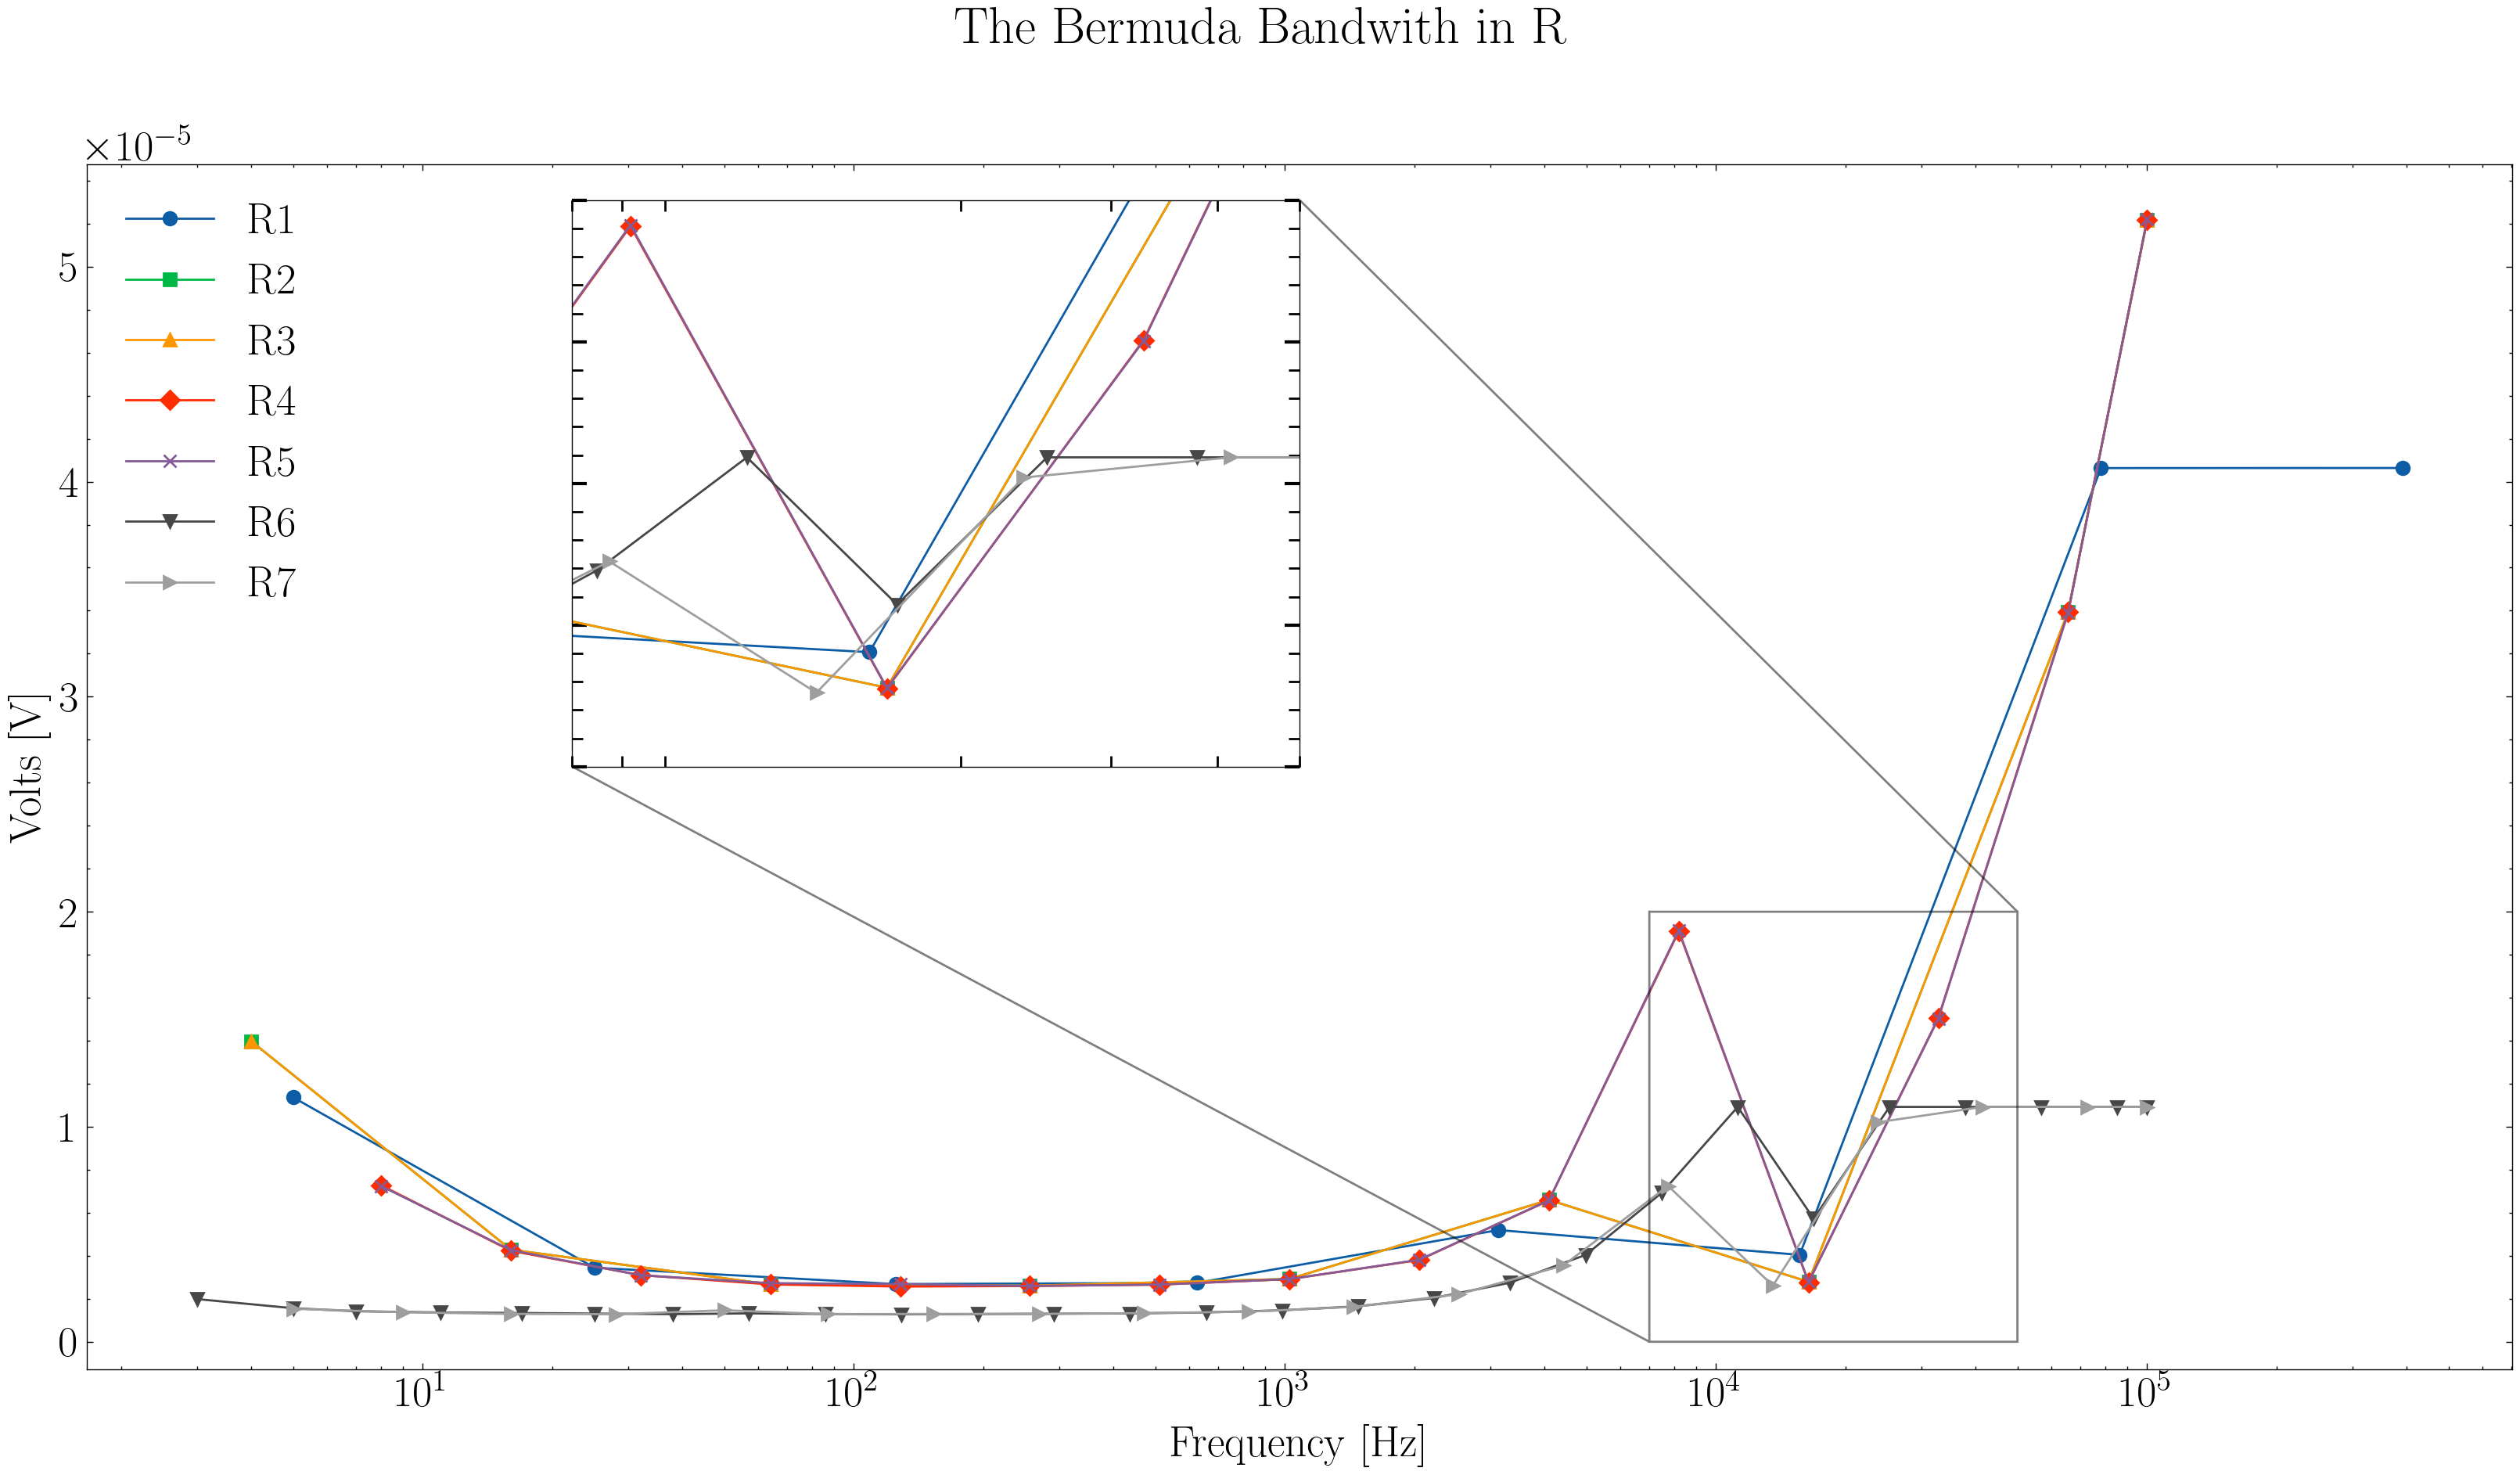

In [ ]:
fig, axes = plt.subplots(1, 1, dpi=200, figsize=(20,10))
# ax = axes[0]
ax = axes
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Volts [V]")
ax.set_xscale("log")
# ax.scatter(freqRange_coll, R)
# ax.scatter(freqRange_coll, X)

# ax.scatter(freqRange_coll, Y)
# ax.plot(freqRange_coll, R, label="R")
# ax.plot(freqRange_coll, X, label="X")
# ax.plot(freqRange_coll, Y, label="Y")



# ax.plot(freqRange_coll1, Theta1, label="Theta1", marker='o')
# ax.plot(freqRange_coll2, Theta2, label="Theta2", marker='s')
# ax.plot(freqRange_coll3, Theta3, label="Theta3", marker='^')
# ax.plot(freqRange_coll4, Theta4, label="Theta4", marker='D')
# ax.plot(freqRange_coll5, Theta5, label="Theta5", marker='x')
# ax.plot(freqRange_coll6, Theta6, label="Theta6", marker='v')
# ax.plot(freqRange_coll7, Theta7, label="Theta7", marker='>')

# x1, x2 = 7*1e3, 5*1e4
# y1, y2 = -1e-6, 2*1e-5
# axins = ax.inset_axes(
#     [0.2, 0.5, 0.3, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2),xscale="log", xticklabels=[], yticklabels=[]
# )
# # axins.set_xscale("log")
# axins.set_xticklabels([])
# axins.set_xticks([])
# axins.tick_params(
#     axis="both",
#     which="both",
#     # bottom=False,
#     # top=False,
#     # left=False,
#     # right=False,
#     labelbottom=False,
#     labelleft=False
# )
# axins.tick_params('both', length=7, width=1.5, which='major')
# axins.tick_params('both', length=5, width=1, which='minor')
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# ax.indicate_inset_zoom(axins, edgecolor="black")


# ax.plot(freqRange_coll1, X1, label="X1", marker='o')
# ax.plot(freqRange_coll2, X2, label="X2", marker='s')
# ax.plot(freqRange_coll3, X3, label="X3", marker='^')
# ax.plot(freqRange_coll4, X4, label="X4", marker='D')
# ax.plot(freqRange_coll5, X5, label="X5", marker='x')
# ax.plot(freqRange_coll6, X6, label="X6", marker='v')
# ax.plot(freqRange_coll7, X7, label="X7", marker='>')
# ax.tick_params('both', length=7, width=1.5, which='major')
# ax.tick_params('both', length=5, width=1, which='minor')


# axins.plot(freqRange_coll1, X1, label="X1", marker='o')
# axins.plot(freqRange_coll2, X2, label="X2", marker='s')
# axins.plot(freqRange_coll3, X3, label="X3", marker='^')
# axins.plot(freqRange_coll4, X4, label="X4", marker='D')
# axins.plot(freqRange_coll5, X5, label="X5", marker='x')
# axins.plot(freqRange_coll6, X6, label="X6", marker='v')
# axins.plot(freqRange_coll7, X7, label="X7", marker='>')
# # axins.grid()


# axins.set_yscale("log")


# ax.plot(freqRange_coll1, Y1, label="Y1", marker='o')
# ax.plot(freqRange_coll2, Y2, label="Y2", marker='s')
# ax.plot(freqRange_coll3, Y3, label="Y3", marker='^')
# ax.plot(freqRange_coll4, Y4, label="Y4", marker='D')
# ax.plot(freqRange_coll5, Y5, label="Y5", marker='x')
# ax.plot(freqRange_coll6, Y6, label="Y6", marker='v')
# ax.plot(freqRange_coll7, Y7, label="Y7", marker='>')

# x1, x2 = 7*1e3, 3*1e4
# y1, y2 = -1.2*1e-5, 2*1e-5
# axins = ax.inset_axes(
#     [0.2, 0.5, 0.3, 0.47],
#     xlim=(x1, x2), ylim=(y1, y2),xscale="log", xticklabels=[], yticklabels=[]
# )
# axins.set_xscale("log")
# axins.set_xticklabels([])
# axins.set_xticks([])
# axins.tick_params(
#     axis="both",
#     which="both",
#     # bottom=False,
#     # top=False,
#     # left=False,
#     # right=False,
#     labelbottom=False,
#     labelleft=False
# )
# axins.tick_params('both', length=7, width=1.5, which='major')
# axins.tick_params('both', length=5, width=1, which='minor')
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# ax.indicate_inset_zoom(axins, edgecolor="black")

# axins.plot(freqRange_coll1, Y1, label="Y1", marker='o')
# axins.plot(freqRange_coll2, Y2, label="Y2", marker='s')
# axins.plot(freqRange_coll3, Y3, label="Y3", marker='^')
# axins.plot(freqRange_coll4, Y4, label="Y4", marker='D')
# axins.plot(freqRange_coll5, Y5, label="Y5", marker='x')
# axins.plot(freqRange_coll6, Y6, label="Y6", marker='v')
# axins.plot(freqRange_coll7, Y7, label="Y7", marker='>')

x1, x2 = 7*1e3, 5*1e4
y1, y2 = 0, 2*1e-5
axins = ax.inset_axes(
    [0.2, 0.5, 0.3, 0.47],
    xlim=(x1, x2), ylim=(y1, y2),xscale="log", xticklabels=[], yticklabels=[]
)
axins.set_xscale("log")
axins.set_xticklabels([])
axins.set_xticks([])
axins.tick_params(
    axis="both",
    which="both",
    # bottom=False,
    # top=False,
    # left=False,
    # right=False,
    labelbottom=False,
    labelleft=False
)
axins.tick_params('both', length=7, width=1.5, which='major')
axins.tick_params('both', length=5, width=1, which='minor')
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.plot(freqRange_coll1, R1, label="R1", marker='o')
ax.plot(freqRange_coll2, R2, label="R2", marker='s')
ax.plot(freqRange_coll3, R3, label="R3", marker='^')
ax.plot(freqRange_coll4, R4, label="R4", marker='D')
ax.plot(freqRange_coll5, R5, label="R5", marker='x')
ax.plot(freqRange_coll6, R6, label="R6", marker='v')
ax.plot(freqRange_coll7, R7, label="R7", marker='>')

axins.plot(freqRange_coll1, R1, label="R1", marker='o')
axins.plot(freqRange_coll2, R2, label="R2", marker='s')
axins.plot(freqRange_coll3, R3, label="R3", marker='^')
axins.plot(freqRange_coll4, R4, label="R4", marker='D')
axins.plot(freqRange_coll5, R5, label="R5", marker='x')
axins.plot(freqRange_coll6, R6, label="R6", marker='v')
axins.plot(freqRange_coll7, R7, label="R7", marker='>')



# ax.axvline(freqRange_coll[4])
# print(freqRange_coll[4])
# ax.plot(freqRange_coll, Theta, label="Y")
# ax.errorbar(freqRange_coll, R, yerr=noiseR)
ax.legend()
fig.suptitle("The Bermuda Bandwith in R")
# ax = axes[1]
# ax.set_xlabel("Frequency [Hz]")
# ax.set_ylabel(r"Resistance of the Wire [$m\Omega$]")
# ax.plot(freqRange_coll, Resistance, label="$R_R$")
# ax.plot(freqRange_coll, ResistanceX, label="$R_X$")
# ax.scatter(freqRange_coll, Resistance)
# ax.scatter(freqRange_coll, ResistanceX)
# ax.set_xscale("log")
# fig.suptitle("Resistance vs frequency")
# ax.legend()
# fig.savefig("images/TheBermudaBandwith_R.png", dpi=300)

In [277]:
 noiseX2,X2

(array([5.15608654e-08, 6.01382482e-09, 0.00000000e+00, 6.66348257e-09,
        3.33174129e-09, 8.47032947e-22, 4.23516474e-22, 6.00329909e-09,
        6.82589921e-09]),
 array([7.838814e-06, 3.803539e-06, 2.644970e-06, 2.510860e-06,
        2.920640e-06, 5.319740e-06, 1.892450e-06, 1.951688e-05,
        3.011091e-05]))

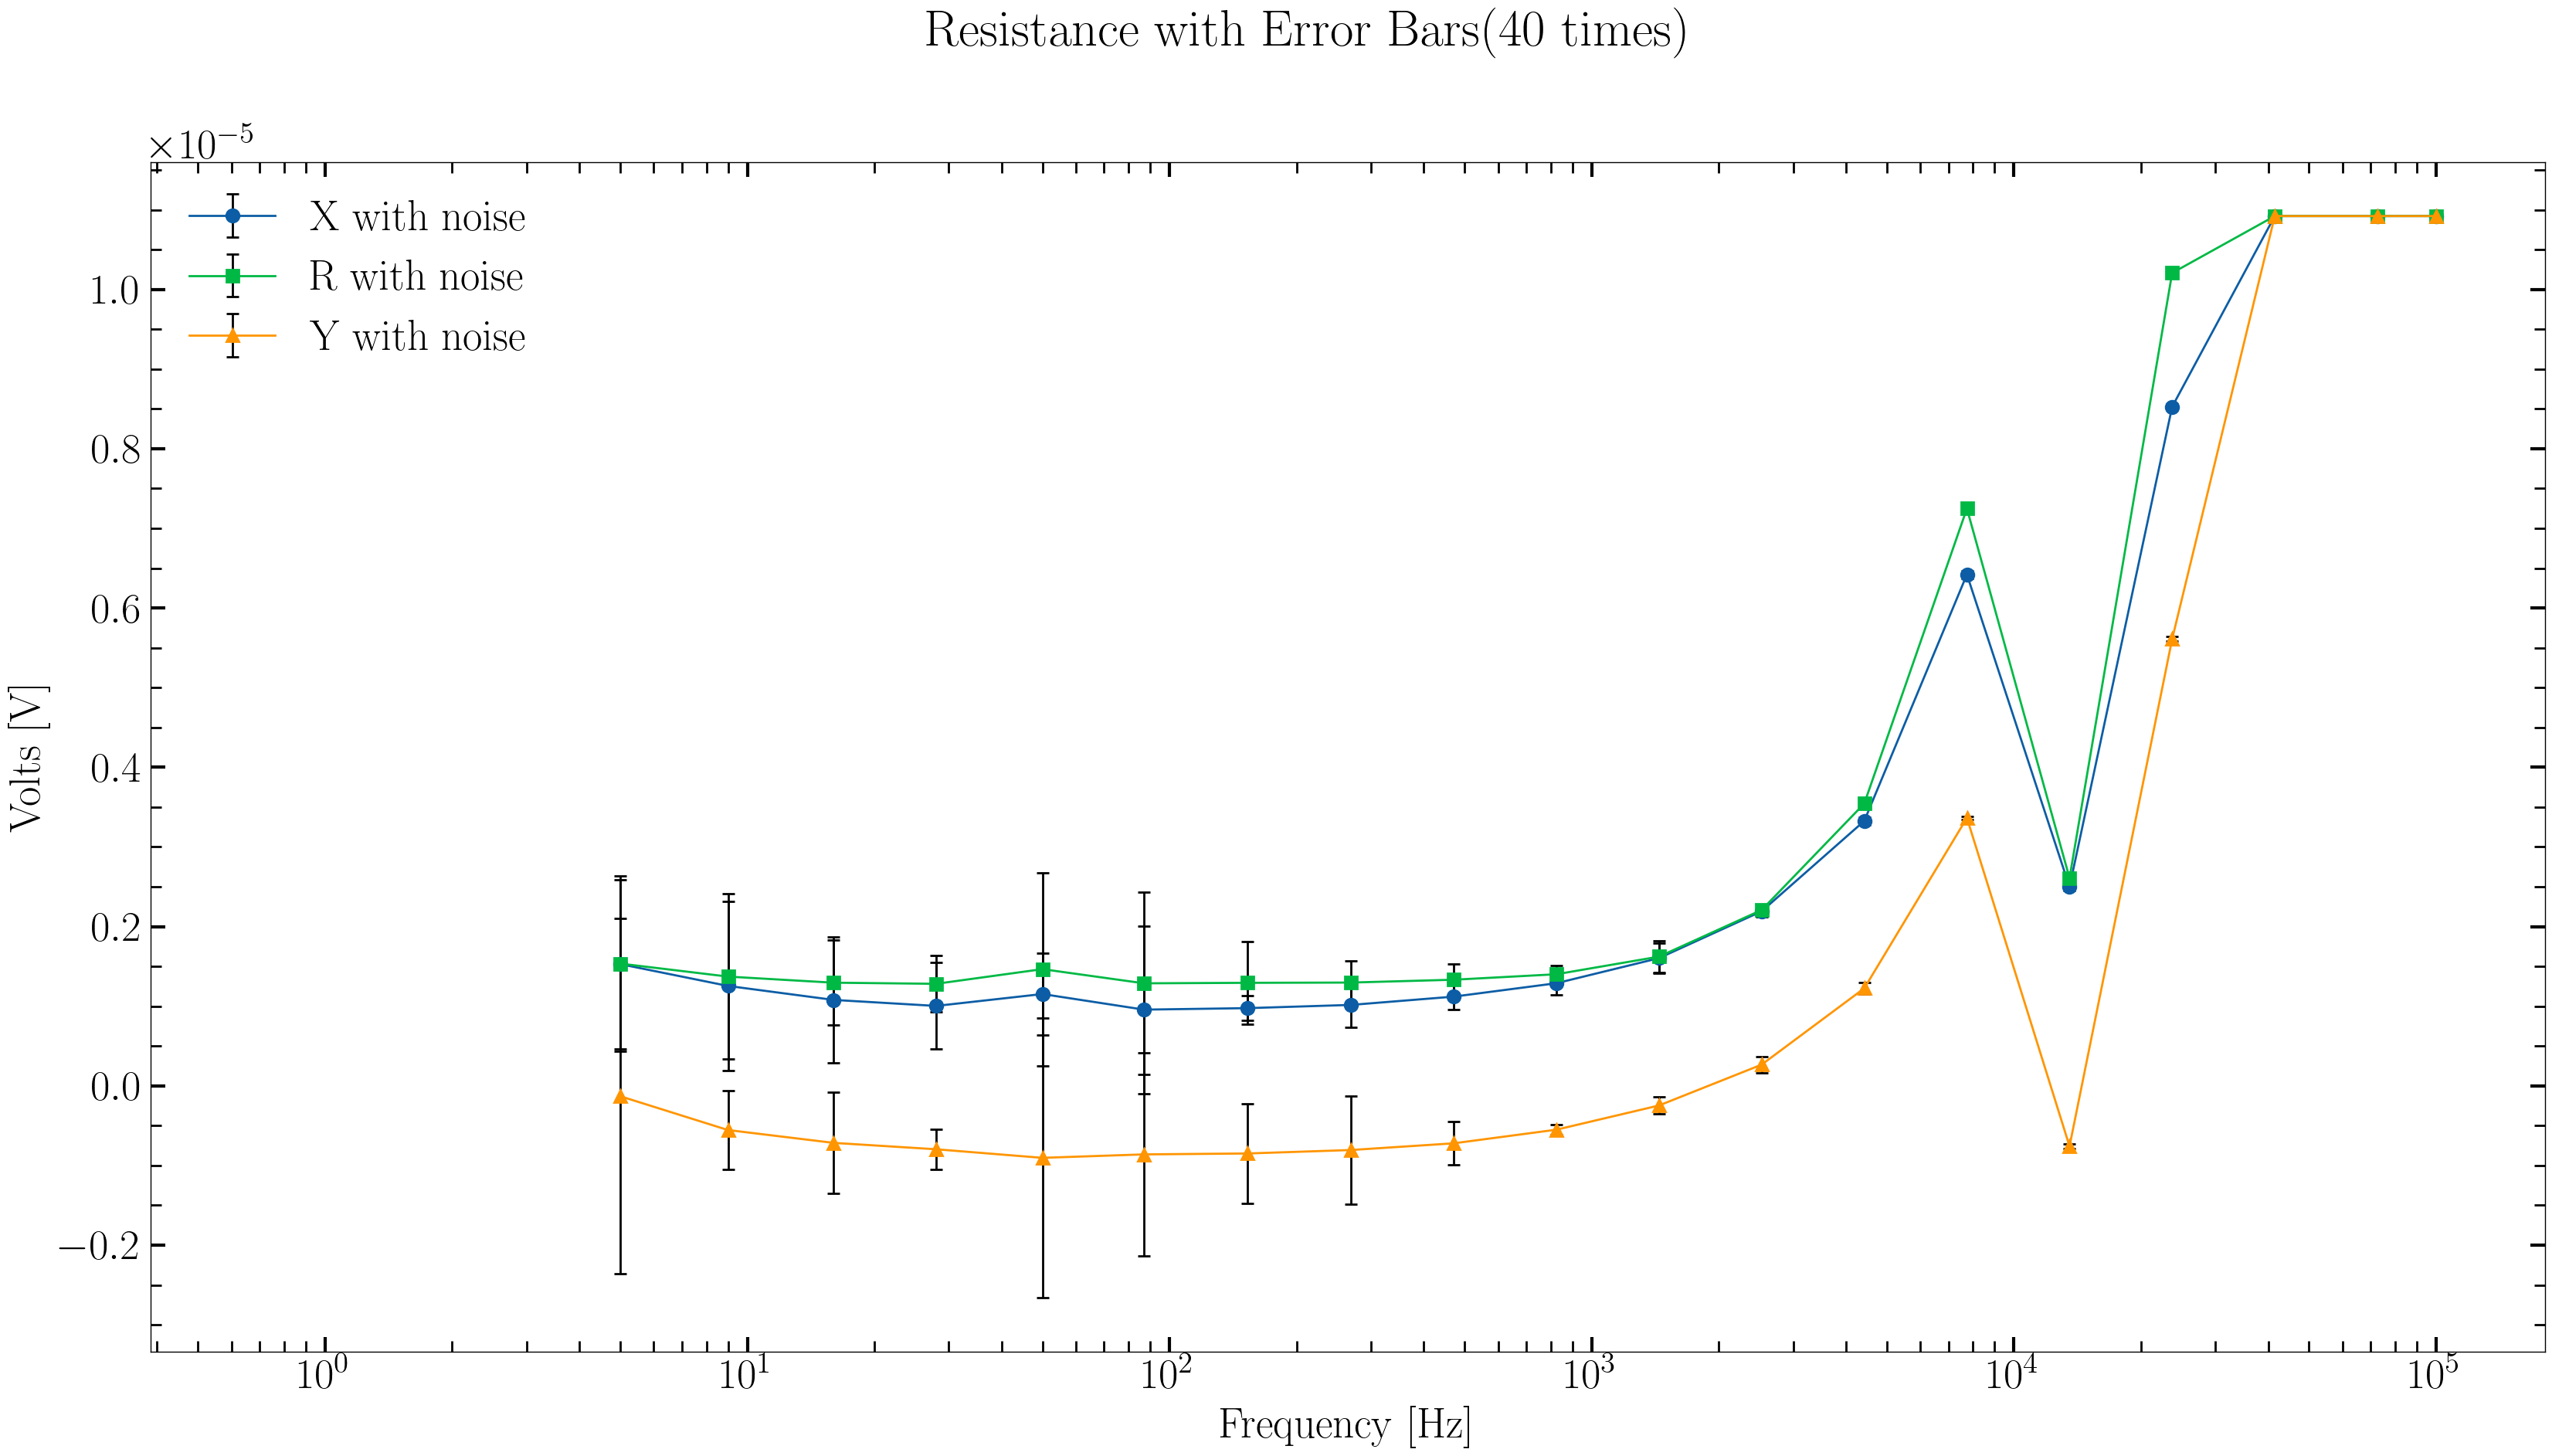

In [301]:
fig, axes = plt.subplots(1, 1, dpi=200, figsize=(20,10))
# ax = axes[0]
ax = axes
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Volts [V]")
ax.set_xscale("log")
# ax.scatter(freqRange_coll, R)
# ax.scatter(freqRange_coll, X)

# ax.scatter(freqRange_coll, Y)
# ax.plot(freqRange_coll, R, label="R")
# ax.plot(freqRange_coll, X, label="X")
# ax.plot(freqRange_coll, Y, label="Y")



# ax.plot(freqRange_coll2, X2, label="X1", marker='o')
# ax.plot(freqRange_coll1, R1, label="R1", marker='o')
# ax.plot(freqRange_coll1, Y1, label="Y1", marker='o')

# ax.errorbar(freqRange_coll1, X1, yerr=2*1e-5, label="noiseX1")
ax.errorbar(freqRange_coll7, X7, yerr=40*noiseX7, label="X with noise", marker='o', capsize=3, ecolor='black')
ax.errorbar(freqRange_coll7, R7, yerr=40*noiseR7, label="R with noise", marker='s', capsize=3, ecolor='black')
ax.errorbar(freqRange_coll7, Y7, yerr=40*noiseY7, label="Y with noise", marker='^', capsize=3, ecolor='black') 
ax.tick_params('both', length=7, width=1.5, which='major')
ax.tick_params('both', length=5, width=1, which='minor')
fig.suptitle("Resistance with Error Bars(40 times)")
ax.legend()
fig.savefig("images/Res_vs_Freq_with_Error_Bars_dat386.png", dpi=300)



In [134]:
def linfit(x,a,b):
    y = a*x+b
    return y
def logfit(x,a,b,c):
    y = a/(np.pow(x,b))
    y = y+c
    return y
xf = np.log(freqRange_coll[fc_start:fc_cutoff])
yf = np.log((noiseX**2)[fc_start:fc_cutoff])

# xf1 = freqRange_coll[:fc_cutoff]
# yf1 = (noiseX**2)[:fc_cutoff]


params, pcov = curve_fit(linfit, xf,yf)
# params1, pcov1 = curve_fit(logfit, xf1,yf1, p0 = [0,2,0], maxfev = 10000)
perr = np.sqrt(np.diag(pcov))
# perr1 = np.sqrt(np.diag(pcov1))

params, perr

(array([ -1.11666465, -28.28094209]), array([0.13393105, 0.88808376]))

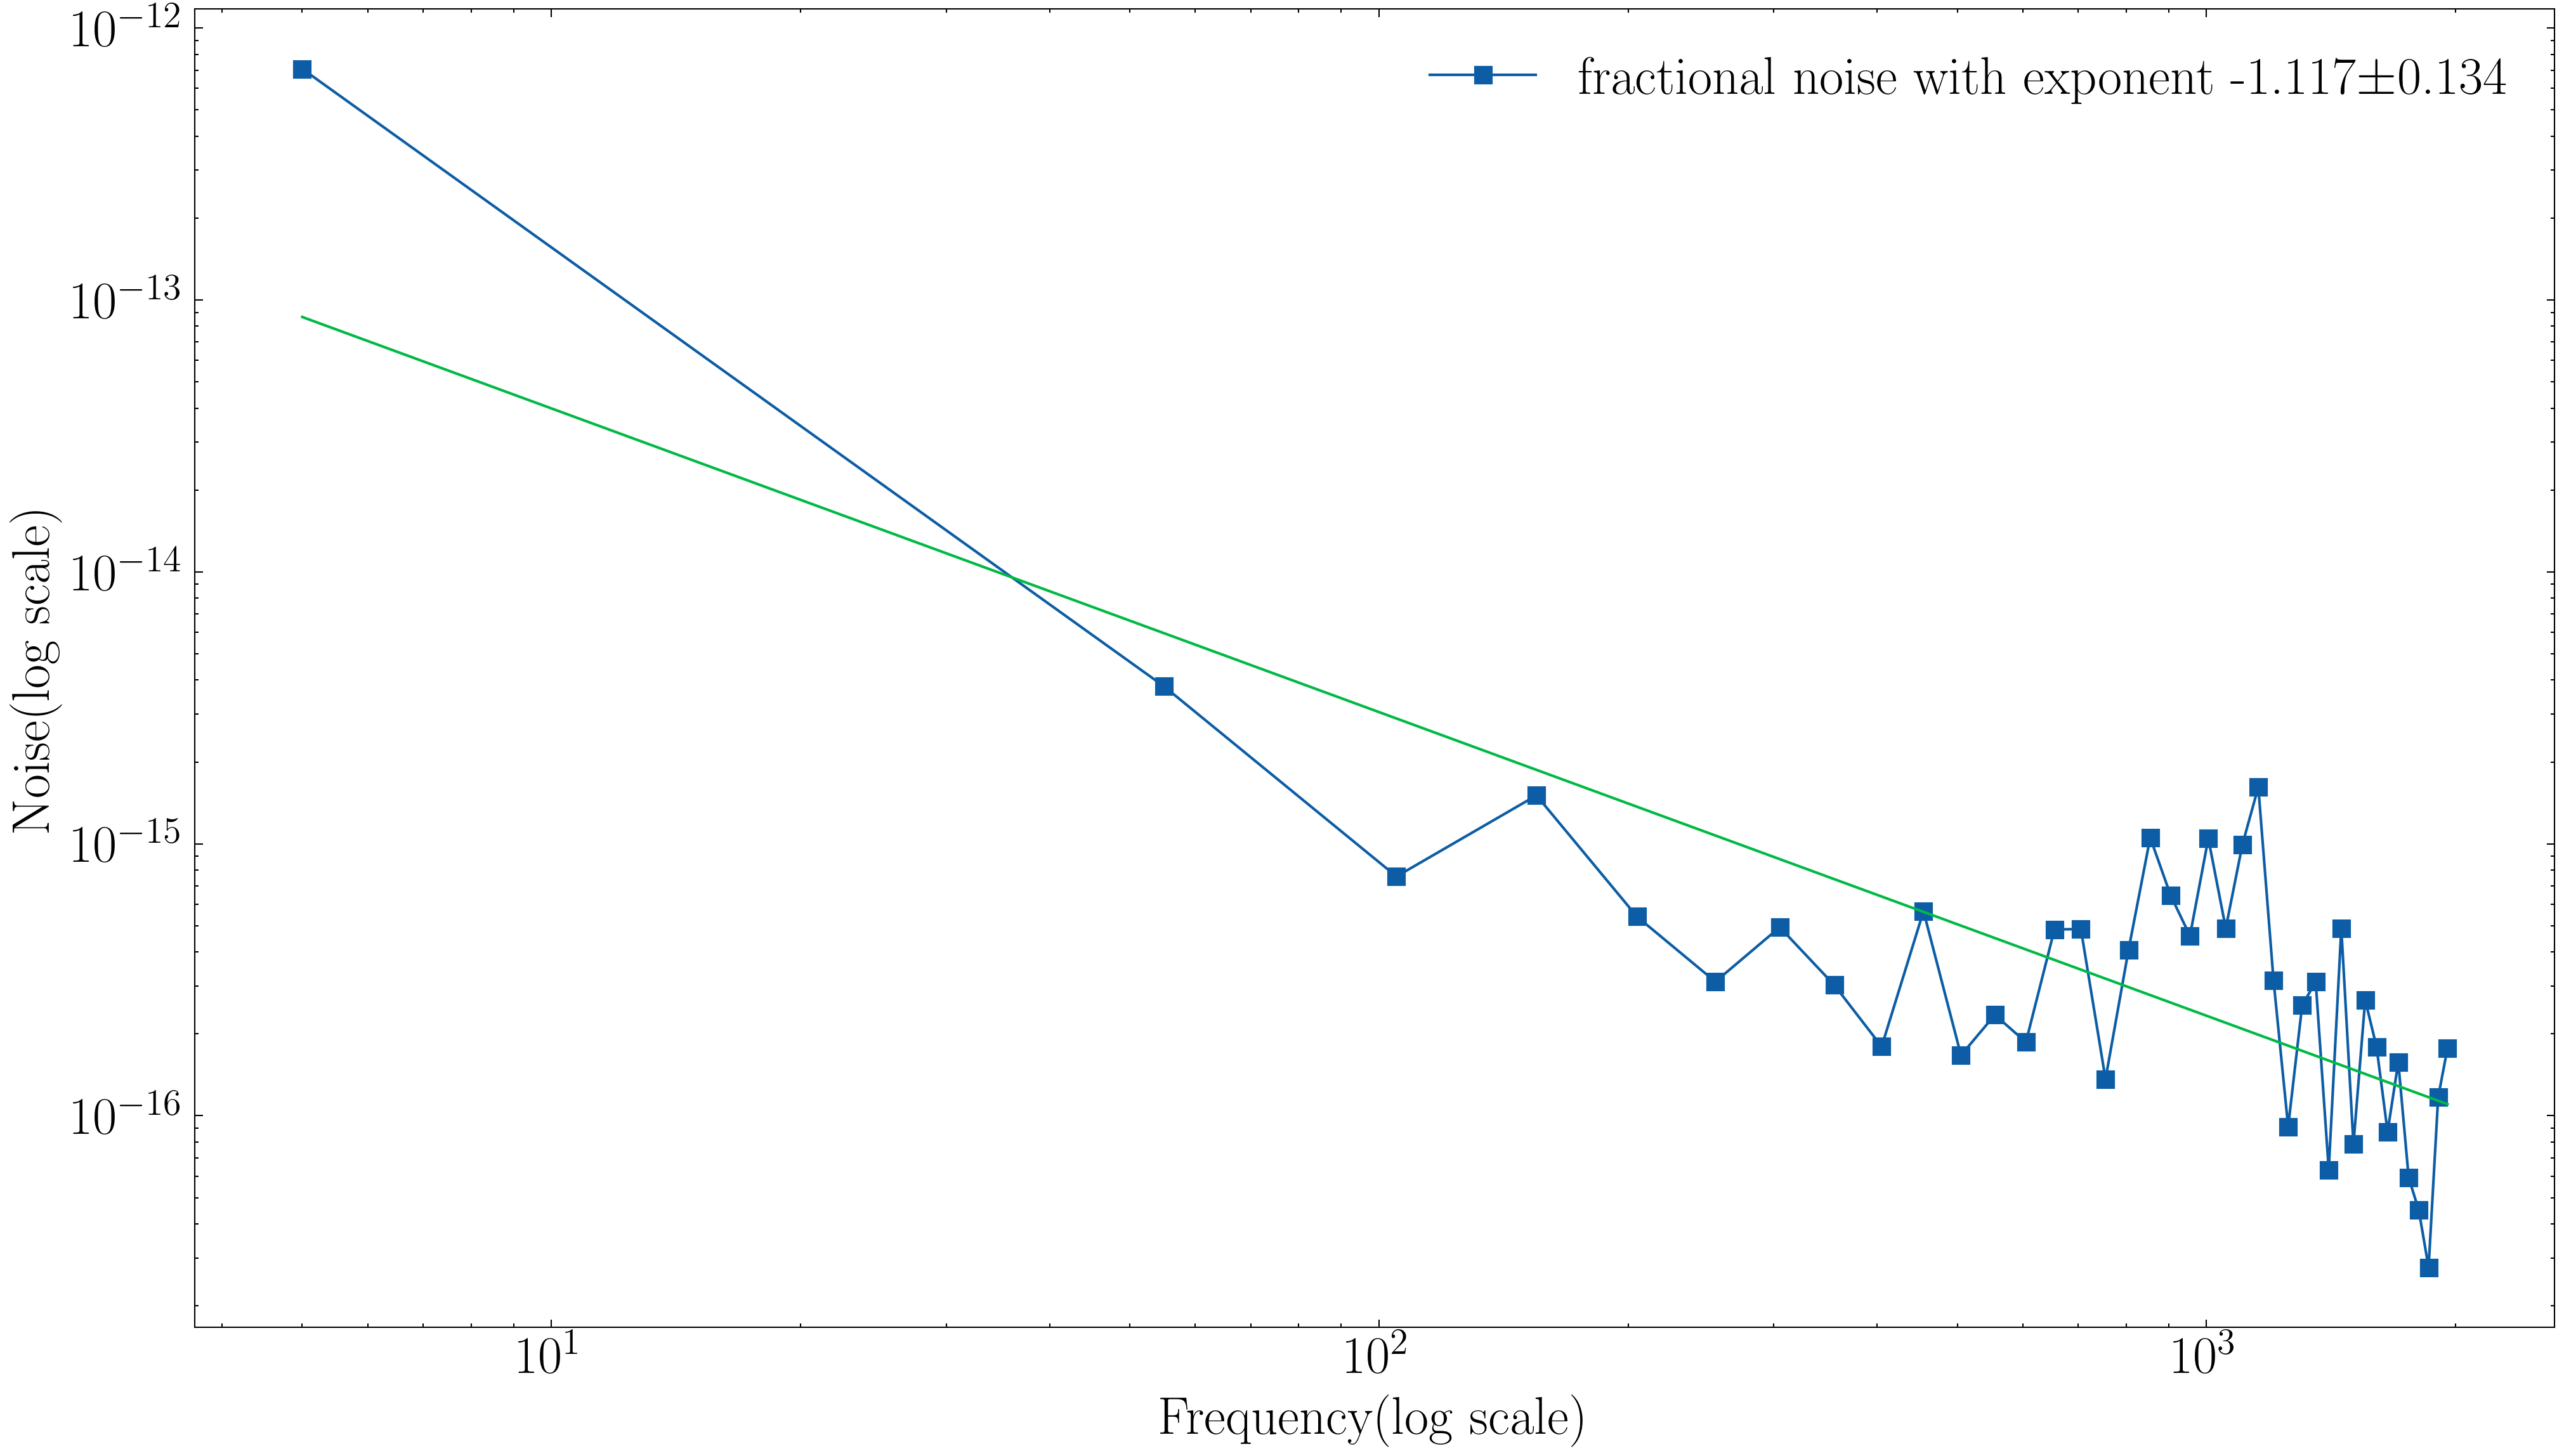

In [135]:
fig, axes = plt.subplots(1,1, dpi =300, figsize = (16,9))
fc_cutoff = -1
fc_start = 0
axes.set_xscale("log")
axes.set_yscale("log")
# axes.plot(freqRange_coll[:fc_cutoff], (noiseX**2)[:fc_cutoff], marker = "s", label = f"fractional noise with exponent ")
axes.plot(freqRange_coll[fc_start:fc_cutoff], (noiseX**2)[fc_start:fc_cutoff], marker = "s", label = f"fractional noise with exponent {params[0]:.3f}" + r"$\pm$" + f"{perr[0]:.3f}")
axes.legend()
yval = pow(freqRange_coll[fc_start:fc_cutoff], params[0])*np.exp(params[-1])
axes.plot(freqRange_coll[fc_start:fc_cutoff], yval)

# axes.plot(freqRange_coll, 1/freqRange_coll)
axes.set_xlabel("Frequency(log scale)")
axes.set_ylabel("Noise(log scale)")
fig.savefig("images/flicker_sync_filteroff_data814_ini_dat_r.png", dpi=300)

In [ ]:
freqRange_coll[-5]

In [ ]:
freqRange_coll[:fc_cutoff]